In [1]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
import matplotlib.pyplot as plt
import numpy as np
import joblib


In [2]:
# Load the saved CNN model
cnn_model = load_model(r"C:\Users\K M SASTRY\Desktop\CAPSTONE PROJECT\cnn_model.h5")
cnn_model = tf.keras.Model(inputs=cnn_model.input, outputs=cnn_model.get_layer('flatten').output)

# Freeze the CNN layers
for layer in cnn_model.layers:
    layer.trainable = False


In [3]:
# Dataset paths
train_dir = r"K:\PROJECT\ORGANISED DATASET\train"
test_dir = r"K:\PROJECT\ORGANISED DATASET\test"

# Data generators for train and test datasets
train_datagen = ImageDataGenerator(rescale=1.0 / 255.0)
test_datagen = ImageDataGenerator(rescale=1.0 / 255.0)

train_generator = train_datagen.flow_from_directory(
    train_dir, target_size=(224, 224), batch_size=32, class_mode='binary', shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    test_dir, target_size=(224, 224), batch_size=32, class_mode='binary', shuffle=False
)


Found 6185 images belonging to 2 classes.
Found 1724 images belonging to 2 classes.


In [4]:
# Function to extract features
def extract_features(generator, model):
    features = model.predict(generator, verbose=1)
    labels = generator.classes
    return features, labels

# Extract features from CNN
train_features, train_labels = extract_features(train_generator, cnn_model)
test_features, test_labels = extract_features(test_generator, cnn_model)

# Print number of features extracted
print(f"Number of features before PCA: {train_features.shape[1]}")


54/54 [==============================] - 38s 712ms/step
Number of features before PCA: 86528


In [5]:
# Scale the features
scaler = StandardScaler()
train_features_scaled = scaler.fit_transform(train_features)
test_features_scaled = scaler.transform(test_features)


In [6]:
# Apply PCA to retain 95% variance
pca = PCA(n_components=0.95, random_state=42)
train_features_pca = pca.fit_transform(train_features_scaled)
test_features_pca = pca.transform(test_features_scaled)

# Print number of features after PCA
print(f"Number of features after PCA: {train_features_pca.shape[1]}")


Number of features after PCA: 389


In [7]:
# Train Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(train_features_pca, train_labels)


RandomForestClassifier(random_state=42)

In [8]:
# Predict on test data
test_predictions = rf_classifier.predict(test_features_pca)

# Accuracy and classification report
accuracy = accuracy_score(test_labels, test_predictions)
print(f"Test Accuracy with PCA: {accuracy:.4f}")

Test Accuracy with PCA: 0.8590


In [9]:
print("Classification Report with PCA:")
print(classification_report(test_labels, test_predictions, target_names=test_generator.class_indices.keys()))

Classification Report with PCA:
              precision    recall  f1-score   support

      BENIGN       0.84      0.68      0.75       542
   MALIGNANT       0.86      0.94      0.90      1182

    accuracy                           0.86      1724
   macro avg       0.85      0.81      0.83      1724
weighted avg       0.86      0.86      0.85      1724



1/1 [==============================] - 0s 104ms/step


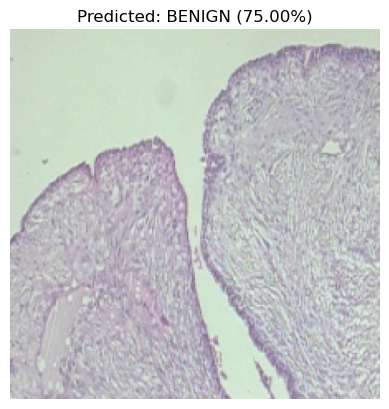

Prediction Probabilities:
BENIGN: 75.00%
MALIGNANT: 25.00%


In [10]:
# Function to predict a single image
def predict_image(image_path, cnn_model, rf_classifier, scaler, pca, class_indices):
    # Load and preprocess the image
    img = load_img(image_path, target_size=(224, 224))
    img_array = img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Extract features
    features = cnn_model.predict(img_array)

    # Scale and apply PCA
    features_scaled = scaler.transform(features)
    features_pca = pca.transform(features_scaled)

    # Predict with RF classifier
    prediction = rf_classifier.predict(features_pca)
    probabilities = rf_classifier.predict_proba(features_pca)[0]

    # Map predictions to class labels
    class_labels = {v: k for k, v in class_indices.items()}
    predicted_class = class_labels[prediction[0]]
    confidence = max(probabilities)

    # Display image and prediction
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Predicted: {predicted_class} ({confidence * 100:.2f}%)")
    plt.show()

    # Print probabilities
    print("Prediction Probabilities:")
    for class_label, prob in zip(class_labels.values(), probabilities):
        print(f"{class_label}: {prob * 100:.2f}%")

# Example usage
image_path = r"K:\PROJECT\ORGANISED DATASET\test\BENIGN\phyllodes_tumor\SOB_B_PT_14-21998AB\40X\SOB_B_PT-14-21998AB-40-007.png"
predict_image(image_path, cnn_model, rf_classifier, scaler, pca, train_generator.class_indices)


1/1 [==============================] - 0s 80ms/step


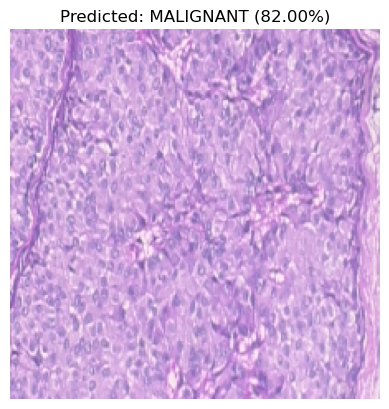

Prediction Probabilities:
BENIGN: 18.00%
MALIGNANT: 82.00%


In [11]:
# Function to predict a single image
def predict_image(image_path, cnn_model, rf_classifier, scaler, pca, class_indices):
    # Load and preprocess the image
    img = load_img(image_path, target_size=(224, 224))
    img_array = img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Extract features
    features = cnn_model.predict(img_array)

    # Scale and apply PCA
    features_scaled = scaler.transform(features)
    features_pca = pca.transform(features_scaled)

    # Predict with RF classifier
    prediction = rf_classifier.predict(features_pca)
    probabilities = rf_classifier.predict_proba(features_pca)[0]

    # Map predictions to class labels
    class_labels = {v: k for k, v in class_indices.items()}
    predicted_class = class_labels[prediction[0]]
    confidence = max(probabilities)

    # Display image and prediction
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Predicted: {predicted_class} ({confidence * 100:.2f}%)")
    plt.show()

    # Print probabilities
    print("Prediction Probabilities:")
    for class_label, prob in zip(class_labels.values(), probabilities):
        print(f"{class_label}: {prob * 100:.2f}%")

# Example usage
image_path = r"K:\PROJECT\ORGANISED DATASET\test\MALIGNANT\mucinous_carcinoma\SOB_M_MC_14-13413\100X\SOB_M_MC-14-13413-100-014.png"
predict_image(image_path, cnn_model, rf_classifier, scaler, pca, train_generator.class_indices)


In [12]:
# Save the Random Forest classifier
joblib.dump(rf_classifier, r'C:\Users\K M SASTRY\Desktop\CAPSTONE PROJECT\rf_model_with_pca.pkl')

# Save the StandardScaler and PCA
joblib.dump(scaler, r'C:\Users\K M SASTRY\Desktop\CAPSTONE PROJECT\scaler_with_pca.pkl')
joblib.dump(pca, r'C:\Users\K M SASTRY\Desktop\CAPSTONE PROJECT\pca_model.pkl')

print("Models and preprocessing objects saved successfully.")


Models and preprocessing objects saved successfully.
